<a href="https://colab.research.google.com/github/aztofighi/Persian_Handwritten_Recognition/blob/main/Persian_Handwritten_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget -q https://github.com/aztofighi/Persian_Handwritten_Recognition/raw/main/Hoda_Dataset/Test_20000.cdb
!wget -q https://github.com/aztofighi/Persian_Handwritten_Recognition/raw/main/Hoda_Dataset/Train_60000.cdb

In [2]:
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.utils import np_utils
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import tensorflow as tf
import random
import struct
import numpy as np
import cv2

In [3]:
# Get the Train and Test data
TRAIN_PATH = 'Train_60000.cdb'
TEST_PATH = 'Test_20000.cdb'

# Image preprocessing

In [4]:
def __convert_to_one_hot(vector, num_classes):
    result = np.zeros(shape=[len(vector), num_classes])
    result[np.arange(len(vector)), vector] = 1
    return result


def __resize_image(src_image, dst_image_height, dst_image_width):
    src_image_height = src_image.shape[0]
    src_image_width = src_image.shape[1]

    if src_image_height > dst_image_height or src_image_width > dst_image_width:
        height_scale = dst_image_height / src_image_height
        width_scale = dst_image_width / src_image_width
        scale = min(height_scale, width_scale)
        img = cv2.resize(src=src_image, dsize=(0, 0), fx=scale, fy=scale, interpolation=cv2.INTER_CUBIC)
    else:
        img = src_image

    img_height = img.shape[0]
    img_width = img.shape[1]

    dst_image = np.zeros(shape=[dst_image_height, dst_image_width], dtype=np.uint8)

    y_offset = (dst_image_height - img_height) // 2
    x_offset = (dst_image_width - img_width) // 2

    dst_image[y_offset:y_offset+img_height, x_offset:x_offset+img_width] = img

    return dst_image


def read_hoda_cdb(file_name):
    with open(file_name, 'rb') as binary_file:

        data = binary_file.read()

        offset = 0

        # read private header

        yy = struct.unpack_from('H', data, offset)[0]
        offset += 2

        m = struct.unpack_from('B', data, offset)[0]
        offset += 1

        d = struct.unpack_from('B', data, offset)[0]
        offset += 1

        H = struct.unpack_from('B', data, offset)[0]
        offset += 1

        W = struct.unpack_from('B', data, offset)[0]
        offset += 1

        TotalRec = struct.unpack_from('I', data, offset)[0]
        offset += 4

        LetterCount = struct.unpack_from('128I', data, offset)
        offset += 128 * 4

        imgType = struct.unpack_from('B', data, offset)[0]  # 0: binary, 1: gray
        offset += 1

        Comments = struct.unpack_from('256c', data, offset)
        offset += 256 * 1

        Reserved = struct.unpack_from('245c', data, offset)
        offset += 245 * 1

        if (W > 0) and (H > 0):
            normal = True
        else:
            normal = False

        images = []
        labels = []

        for i in range(TotalRec):

            StartByte = struct.unpack_from('B', data, offset)[0]  # must be 0xff
            offset += 1

            label = struct.unpack_from('B', data, offset)[0]
            offset += 1

            if not normal:
                W = struct.unpack_from('B', data, offset)[0]
                offset += 1

                H = struct.unpack_from('B', data, offset)[0]
                offset += 1

            ByteCount = struct.unpack_from('H', data, offset)[0]
            offset += 2

            image = np.zeros(shape=[H, W], dtype=np.uint8)

            if imgType == 0:
                # Binary
                for y in range(H):
                    bWhite = True
                    counter = 0
                    while counter < W:
                        WBcount = struct.unpack_from('B', data, offset)[0]
                        offset += 1
                        # x = 0
                        # while x < WBcount:
                        #     if bWhite:
                        #         image[y, x + counter] = 0  # Background
                        #     else:
                        #         image[y, x + counter] = 255  # ForeGround
                        #     x += 1
                        if bWhite:
                            image[y, counter:counter + WBcount] = 0  # Background
                        else:
                            image[y, counter:counter + WBcount] = 255  # ForeGround
                        bWhite = not bWhite  # black white black white ...
                        counter += WBcount
            else:
                # GrayScale mode
                data = struct.unpack_from('{}B'.format(W * H), data, offset)
                offset += W * H
                image = np.asarray(data, dtype=np.uint8).reshape([W, H]).T

            images.append(image)
            labels.append(label)

        return images, labels


def read_hoda_dataset(dataset_path, images_height=32, images_width=32, one_hot=False, reshape=True):
    images, labels = read_hoda_cdb(dataset_path)
    assert len(images) == len(labels)

    X = np.zeros(shape=[len(images), images_height, images_width], dtype=np.float32)
    Y = np.zeros(shape=[len(labels)], dtype=int)

    for i in range(len(images)):
        image = images[i]
        # Image resizing.
        image = __resize_image(src_image=image, dst_image_height=images_height, dst_image_width=images_width)
        # Image normalization.
        image = image / 255
        # Image binarization.
        image = np.where(image >= 0.5, 1, 0)
        # Image.
        X[i] = image
        # Label.
        Y[i] = labels[i]

    if one_hot:
        Y = __convert_to_one_hot(Y, 10).astype(dtype=np.float32)
    else:
        Y = Y.astype(dtype=np.float32)

    if reshape:
        X = X.reshape(-1, images_height * images_width)
    else:
        X = X.reshape(-1, images_height, images_width, 1)

    return X, Y


In [5]:
X_train, Y_train = read_hoda_dataset(dataset_path=TRAIN_PATH,
                                    images_height=32,
                                    images_width=32,
                                    one_hot=False,
                                    reshape=True)

X_test, Y_test = read_hoda_dataset(dataset_path=TEST_PATH,
                                  images_height=32,
                                  images_width=32,
                                  one_hot=False,
                                  reshape=True)

print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(60000, 1024) (60000,)
(20000, 1024) (20000,)


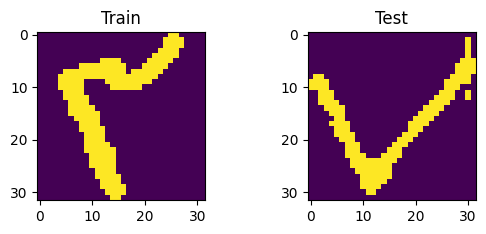

In [6]:
# Plot the Train and Test data
img1 = plt.subplot(221)
train_index = random.randint(0, len(X_train))
test_index = random.randint(0, len(X_test))
img1.set_title('Train')
plt.imshow(X_train[train_index].reshape(32,32))
img2 = plt.subplot(222)
plt.imshow(X_train[test_index].reshape(32,32))
img2.set_title('Test')

plt.show()

In [7]:
# X_train = np.expand_dims(X_train, axis=2)
# X_test = np.expand_dims(X_test, axis=2)

# Normalize the Train and Test data
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

# one hot encode outputs
Y_train = np_utils.to_categorical(Y_train)
Y_test = np_utils.to_categorical(Y_test)
num_classes = Y_test.shape[1]
print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

(60000, 1024) (20000, 1024) (60000, 10) (20000, 10)


In [8]:
def recall_m(y_true, y_pred):
    K = tf.keras.backend
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    K = tf.keras.backend
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    K = tf.keras.backend
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [9]:
# Build model
def build_model():
  model = Sequential()
  model.add(Dense(100, input_shape=(32 * 32,), activation='relu'))
  model.add(Dropout(0.02))
  model.add(Dense(400, activation='relu'))
  model.add(Dense(num_classes, activation='sigmoid'))
  return model

In [10]:
model = build_model()
# Compile
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', f1_m, precision_m, recall_m])

# Fit the model
history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=10, batch_size=200)

Epoch 1/10
300/300 [==============================] - 5s 12ms/step - loss: 0.8828 - accuracy: 0.8007 - f1_m: 0.3958 - precision_m: 0.2494 - recall_m: 0.9639 - val_loss: 0.4717 - val_accuracy: 0.8468 - val_f1_m: 0.4556 - val_precision_m: 0.2997 - val_recall_m: 0.9793
Epoch 2/10
300/300 [==============================] - 3s 11ms/step - loss: 0.2388 - accuracy: 0.9300 - f1_m: 0.4508 - precision_m: 0.2917 - recall_m: 0.9916 - val_loss: 0.3684 - val_accuracy: 0.8853 - val_f1_m: 0.4706 - val_precision_m: 0.3129 - val_recall_m: 0.9837
Epoch 3/10
300/300 [==============================] - 4s 14ms/step - loss: 0.1883 - accuracy: 0.9464 - f1_m: 0.4581 - precision_m: 0.2978 - recall_m: 0.9934 - val_loss: 0.3177 - val_accuracy: 0.9036 - val_f1_m: 0.4753 - val_precision_m: 0.3170 - val_recall_m: 0.9871
Epoch 4/10
300/300 [==============================] - 4s 12ms/step - loss: 0.1607 - accuracy: 0.9544 - f1_m: 0.4668 - precision_m: 0.3050 - recall_m: 0.9945 - val_loss: 0.2898 - val_accuracy: 0.9135 

In [11]:
# Final evaluation of the model
train_eval = model.evaluate(X_train, Y_train, batch_size=200)
test_eval = model.evaluate(X_test, Y_test, batch_size=200)
print("Train eval : ", train_eval)
print("Test eval : ", test_eval)

100/100 [==============================] - 0s 4ms/step - loss: 0.1741 - accuracy: 0.9495 - f1_m: 0.5505 - precision_m: 0.3891 - recall_m: 0.9934
Train eval :  [0.07403614372015, 0.9789666533470154, 0.5408377051353455, 0.37103164196014404, 0.9977160692214966]
Test eval :  [0.17413026094436646, 0.9495000243186951, 0.5504541397094727, 0.3890816569328308, 0.9933501482009888]


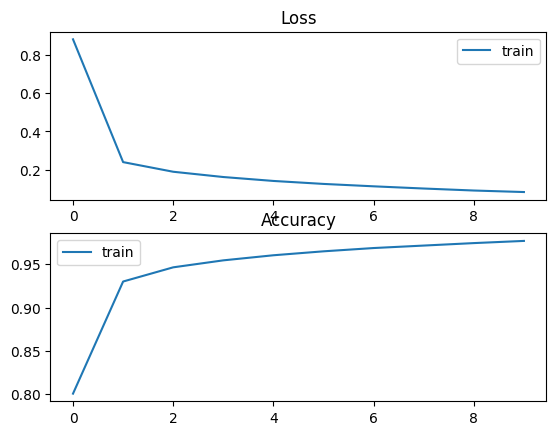

In [12]:
# Plot loss during training
plt.subplot(211)
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.legend()

# Plot accuracy during training
plt.subplot(212)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.legend()

plt.show()


In [13]:
Y_pred = model.predict(X_test, batch_size=200, verbose=1)
print(Y_pred)
print(Y_test)
Y_pred_bool = np.argmax(Y_pred, axis=1)

100/100 [==============================] - 0s 4ms/step
[[9.99615371e-01 2.82823574e-02 3.77129938e-04 ... 3.35588902e-01
  5.29766619e-01 9.17818770e-03]
 [9.99704361e-01 8.23218450e-02 1.39201496e-04 ... 5.86017132e-01
  7.84959257e-01 2.09517987e-03]
 [9.65805411e-01 8.03703487e-01 5.65422961e-05 ... 3.93822819e-01
  1.96043879e-01 6.79266220e-03]
 ...
 [1.77432876e-02 9.78637576e-01 1.24682657e-01 ... 2.81115703e-04
  2.28419714e-03 5.84535241e-01]
 [4.67028189e-03 2.61369022e-03 1.02525065e-02 ... 3.57042978e-07
  6.25559926e-01 9.99877930e-01]
 [1.29963664e-04 2.59882199e-05 1.69776961e-01 ... 9.95254190e-09
  7.16256276e-02 9.99990106e-01]]
[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]


In [14]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = np.argmax(Y_pred, axis=1)
y_true = np.argmax(Y_test, axis=1)

print('Confusion Matrix')
print(confusion_matrix(y_true, y_pred))
print('Classification Report')
target_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
print(classification_report(y_true, y_pred, target_names=target_names))

Confusion Matrix
[[1975    0    0    0    3   18    1    1    2    0]
 [   7 1971    9    0    0    0    4    5    2    2]
 [   4   42 1819   72   25    0   22    1    1   14]
 [   5    1   86 1831   67    1    5    2    0    2]
 [   9    5   20   85 1835   16    9    2    3   16]
 [   7    6    0    1   10 1959    1    3   12    1]
 [   4   20   22    9   18    6 1858    6   13   44]
 [  18    7   20    3    9   13   18 1909    3    0]
 [   6    3    2    0    9   10   11    0 1942   17]
 [   3   38    6    2    8    2   24    0   26 1891]]
Classification Report
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      2000
           1       0.94      0.99      0.96      2000
           2       0.92      0.91      0.91      2000
           3       0.91      0.92      0.91      2000
           4       0.92      0.92      0.92      2000
           5       0.97      0.98      0.97      2000
           6       0.95      0.93      0.94      20